# Case 2: Siemens AI-Driven Sales Forecasting

## Overview
This case study involves building a monthly sales forecasting model using real sales data from Siemens’ Smart Infrastructure Division in Germany. The objective is to apply machine learning techniques to predict future sales based on historical data and macro-economic indicators.

## Business Problem
- Manual sales forecasting is time-consuming and relies on human judgment.  
- Data is scattered across multiple sources, making it difficult to derive insights.  
- Inaccurate forecasts lead to financial losses, such as inefficient inventory management and unsatisfied customers.

## Objective
- Develop an AI-driven predictive model to automate the forecasting process.  
- Evaluate the model using Root Mean Squared Error (RMSE).  
- Submit predictions for May 2022 - February 2023 in a structured CSV format.


---

**This notebook was developed by:**
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564


# 1. Import the Libraries

In [85]:
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, boxcox
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import GridSearchCV

#warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load Datasets

Import Sales Data

In [86]:
sales_data = pd.read_csv("Case2_Sales data.csv")
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


Import Market Data

In [87]:
market_data = pd.read_excel("Case2_Market data.xlsx", header=None)
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,...,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,...,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815


# 3. Sales Dataset Analysis

Check for missing values

In [88]:
sales_data.isna().sum()

DATE          0
Mapped_GCK    0
Sales_EUR     0
dtype: int64

Count occurrences of 0 and non-zero Sales

In [89]:
zero_count = (sales_data["Sales_EUR"] == 0).sum()
non_zero_count = (sales_data["Sales_EUR"] != 0).sum()

print(f"Zero Sales Count: {zero_count}")
print(f"Non-Zero Sales Count: {non_zero_count}")

Zero Sales Count: 7135
Non-Zero Sales Count: 2667


Sales Distribution by Product (excluding 0 sales values)

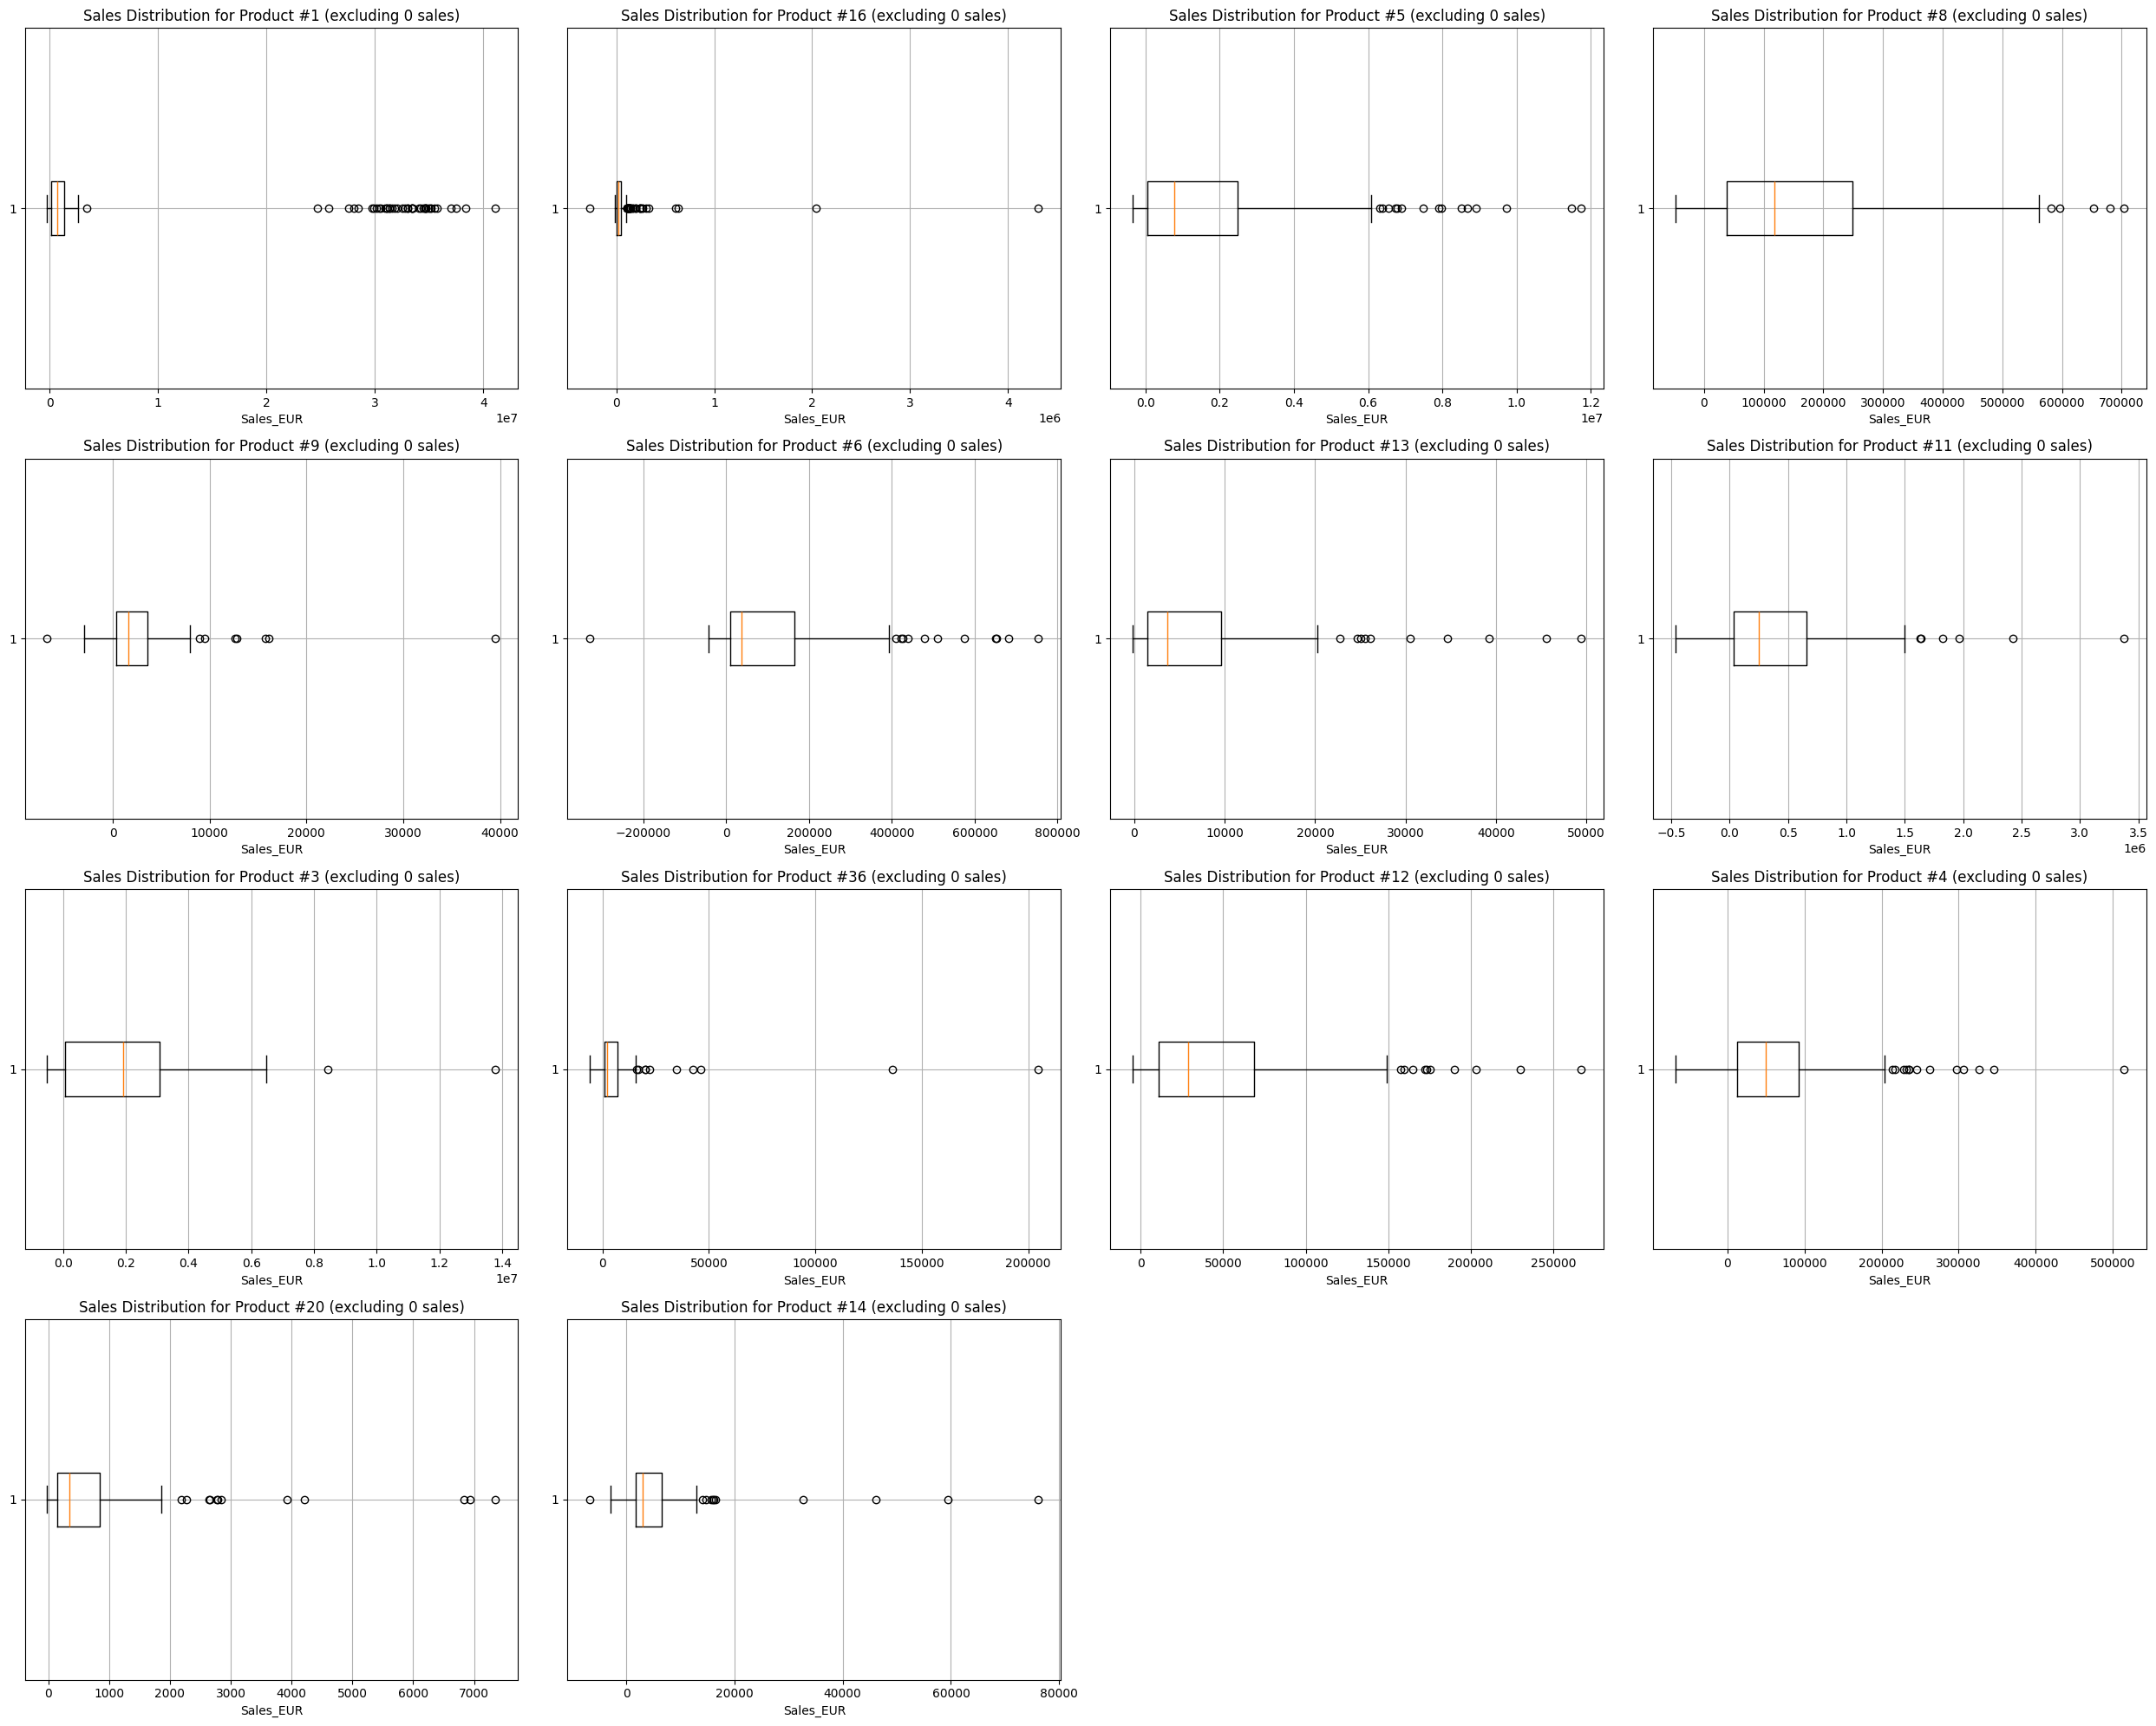

In [90]:
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]
unique_products = filtered_sales["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = filtered_sales[filtered_sales["Mapped_GCK"] == product]["Sales_EUR"]
    axes[i].boxplot(product_data, vert=False)
    axes[i].set_title(f"Sales Distribution for Product {product} (excluding 0 sales)")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [91]:
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], format='%d.%m.%Y')
sales_data['Weekday'] = sales_data['DATE'].dt.day_name()
sales_data['Year'] = sales_data['DATE'].dt.year
sales_data['Month'] = sales_data['DATE'].dt.month
monthly_sales_data = sales_data.groupby(["Mapped_GCK", "Year", "Month"])["Sales_EUR"].sum().reset_index()
print(monthly_sales_data)

    Mapped_GCK  Year  Month  Sales_EUR
0           #1  2018     10   36098918
1           #1  2018     11    5140757
2           #1  2018     12   37889610
3           #1  2019      1   27728146
4           #1  2019      2   34793162
..         ...   ...    ...        ...
597         #9  2021     12      14935
598         #9  2022      1       2065
599         #9  2022      2        902
600         #9  2022      3       4452
601         #9  2022      4       3285

[602 rows x 4 columns]


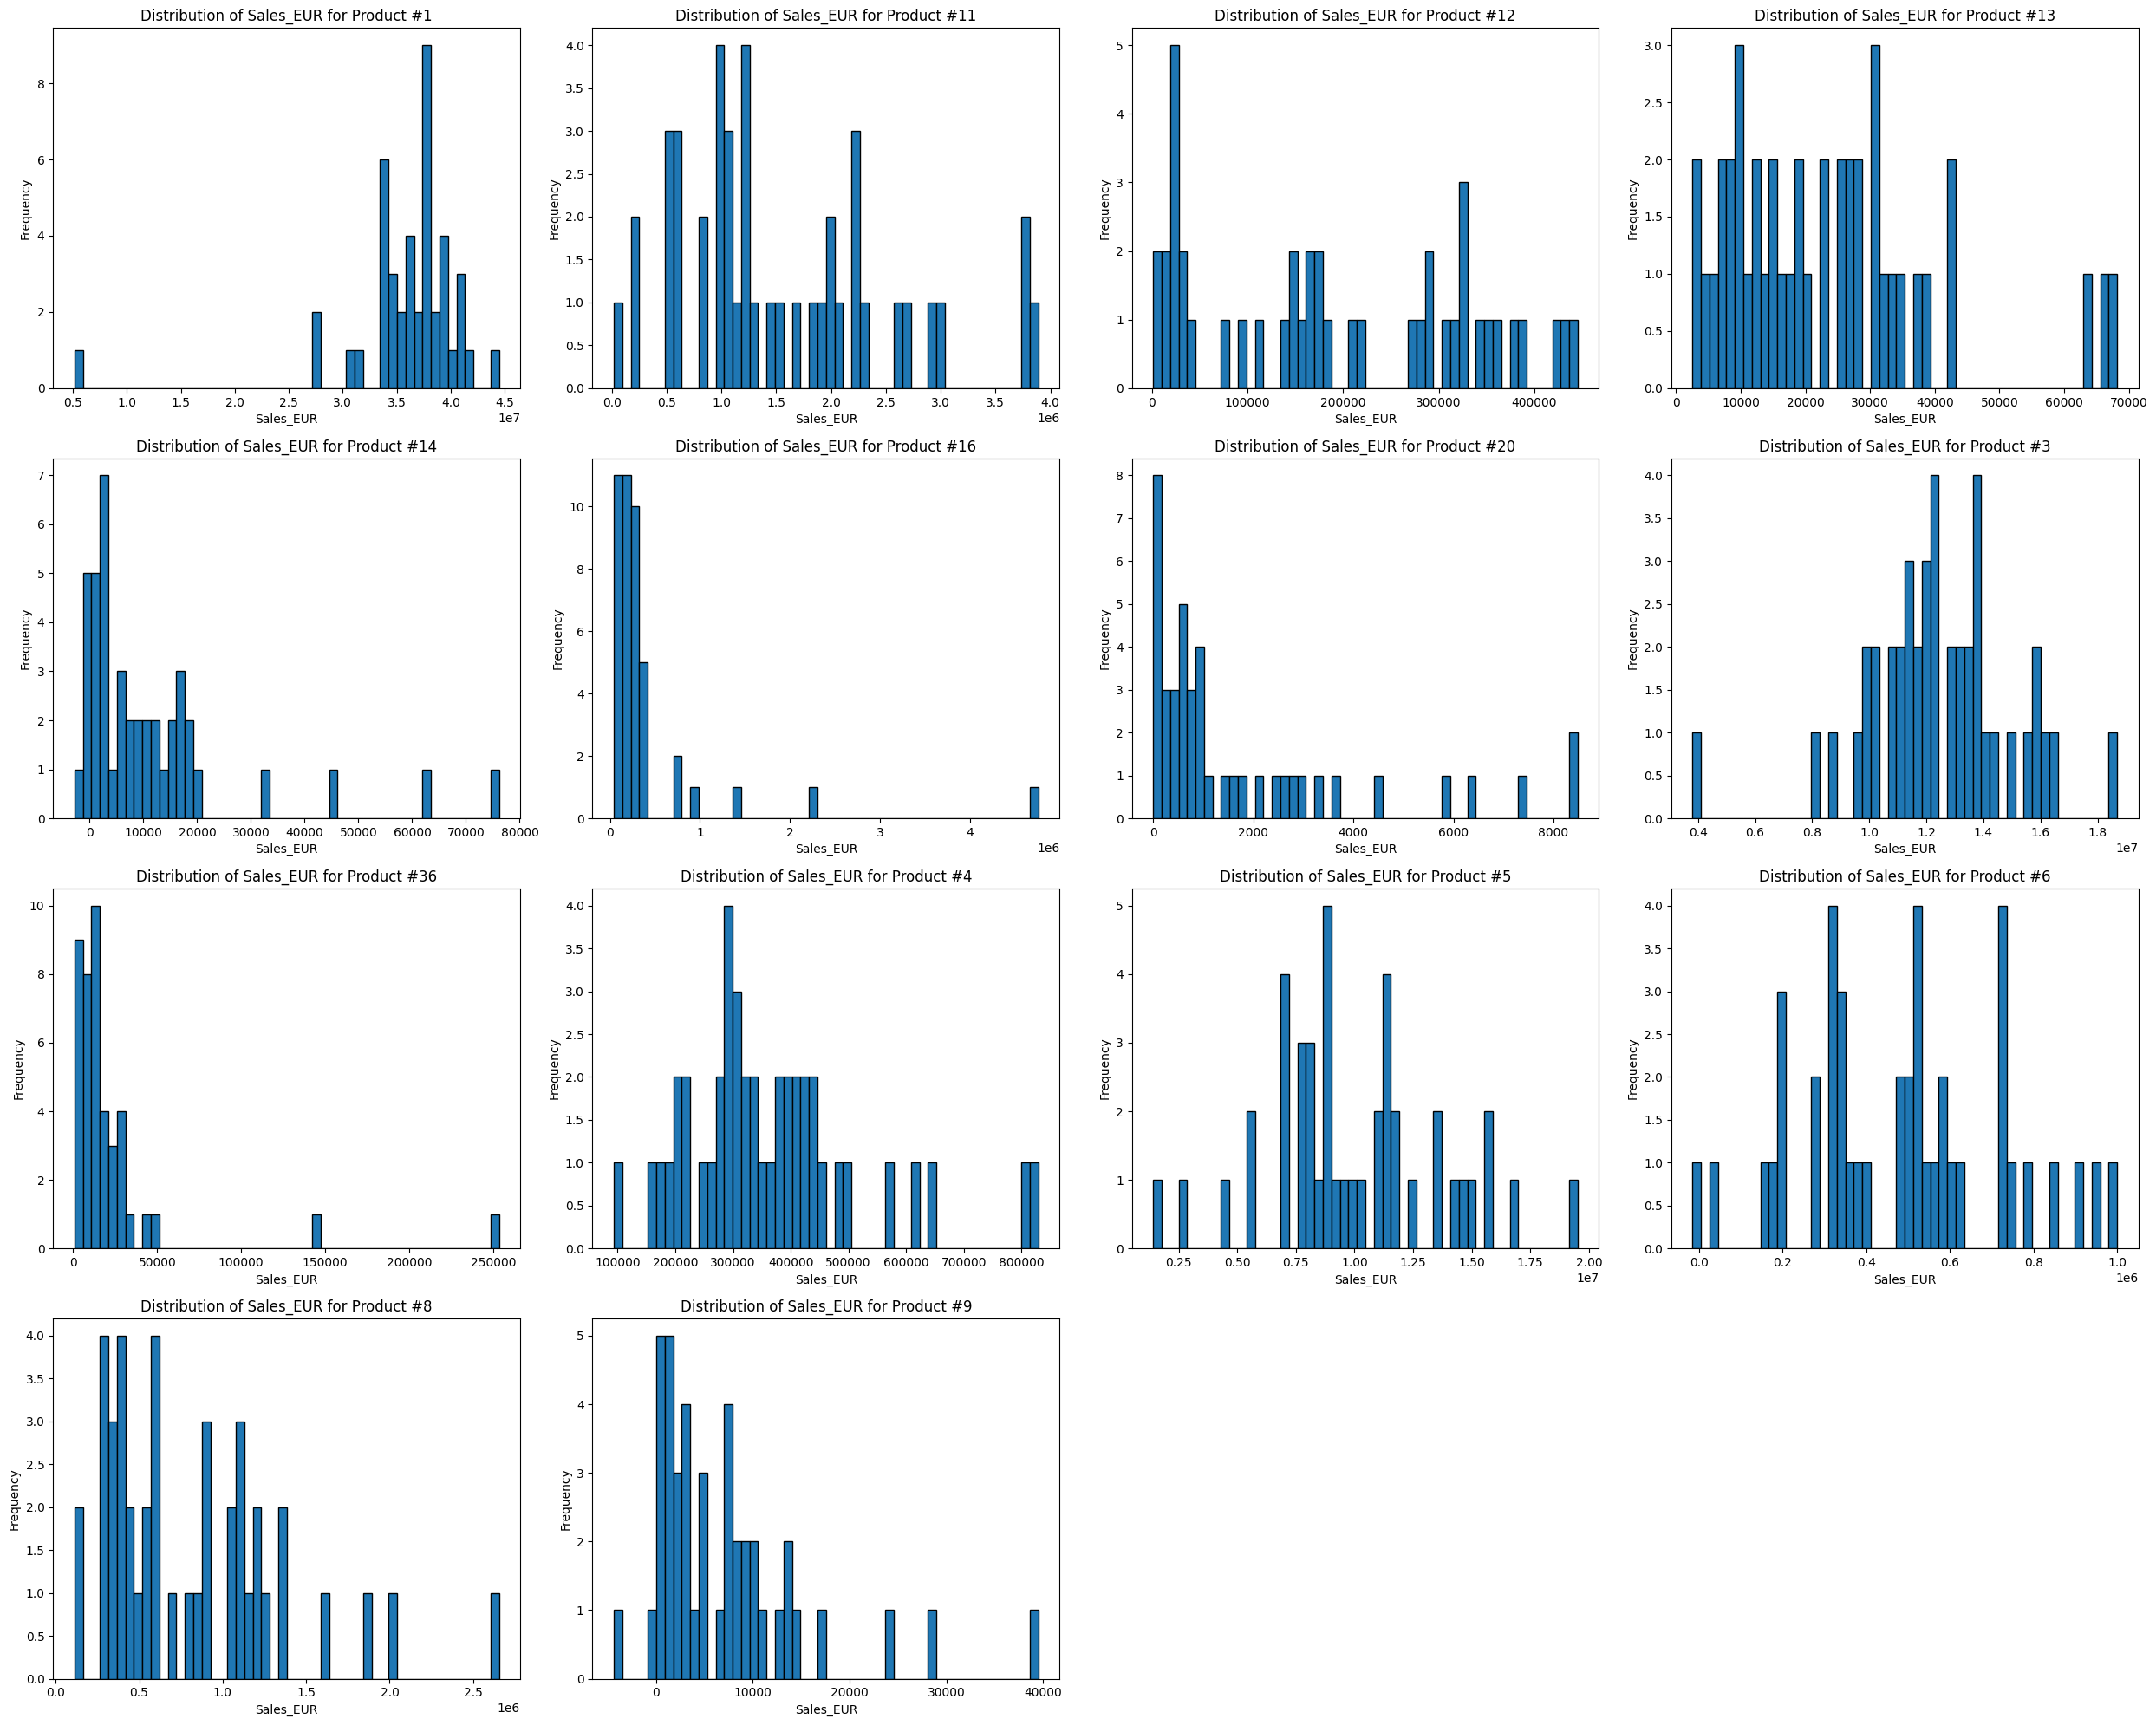

In [92]:
unique_products = monthly_sales_data["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    axes[i].hist(monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]["Sales_EUR"], bins=50, edgecolor="black")
    axes[i].set_title(f"Distribution of Sales_EUR for Product {product}")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

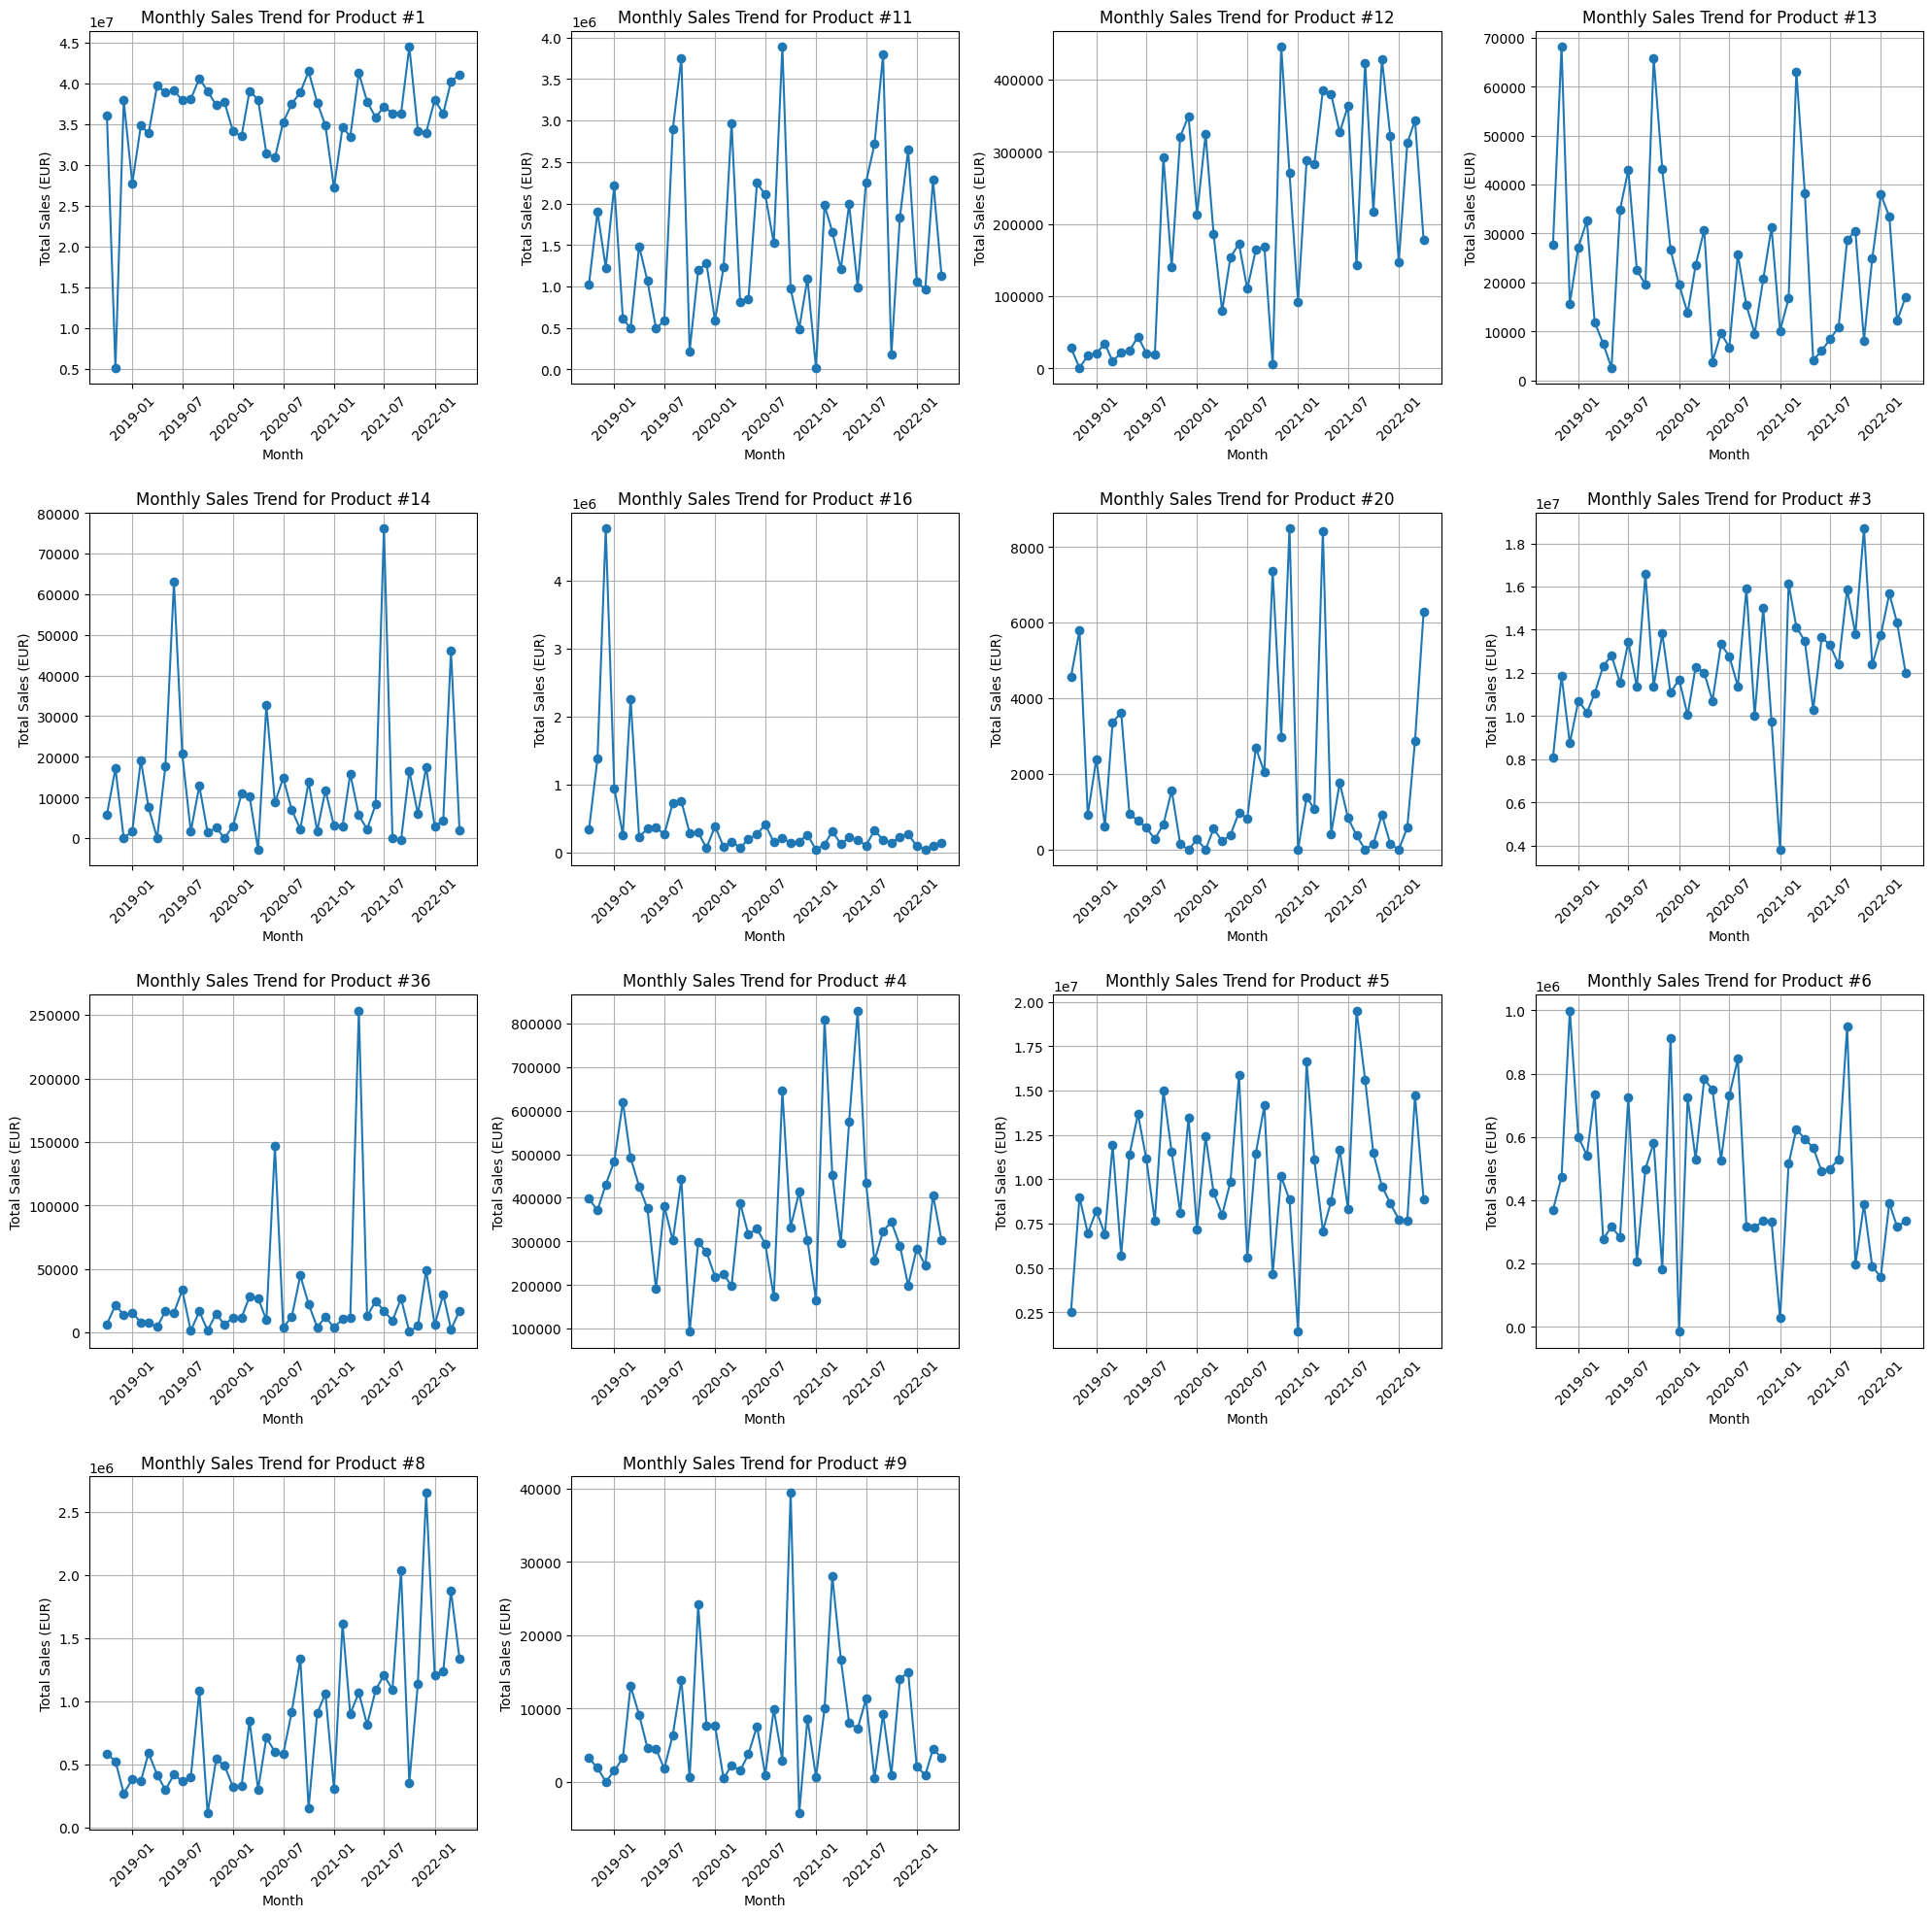

In [93]:
monthly_sales_data["Date"] = pd.to_datetime(monthly_sales_data["Year"].astype(str) + "-" + monthly_sales_data["Month"].astype(str) + "-01")
unique_products = monthly_sales_data["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]
    axes[i].plot(product_data["Date"], product_data["Sales_EUR"], marker="o", linestyle="-")
    axes[i].set_title(f"Monthly Sales Trend for Product {product}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Total Sales (EUR)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

monthly_sales_data = monthly_sales_data.drop(columns=["Date"])

In [94]:
negative_values = monthly_sales_data[monthly_sales_data["Sales_EUR"] < 0]
print(negative_values)

    Mapped_GCK  Year  Month  Sales_EUR
190        #14  2020      4      -2851
207        #14  2021      9       -560
488         #6  2020      1     -15204
584         #9  2020     11      -4358


Check for Duplicate Dates and Their Frequencies

In [95]:
duplicate_dates = sales_data["DATE"].duplicated().sum()
date_counts = sales_data["DATE"].value_counts().sort_index()

print(f"Number of duplicate dates: {duplicate_dates}")
print("\nFirst 10 occurrences of dates:")
print(date_counts.head(10))

Number of duplicate dates: 8586

First 10 occurrences of dates:
DATE
2018-10-01     9
2018-10-02    10
2018-10-03     1
2018-10-04     6
2018-10-05     8
2018-10-06     1
2018-10-08     7
2018-10-09     9
2018-10-10    10
2018-10-11     8
Name: count, dtype: int64


Quantity of Different Products

In [96]:
unique_values = sales_data["Mapped_GCK"].unique()
num_unique_values = len(unique_values)

print(f"Number of unique values in Mapped_GCK: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values in Mapped_GCK: 14
Unique values:
['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']


Distribution of Values by Product

In [97]:
mapped_gck_counts = sales_data["Mapped_GCK"].value_counts()
print("Count of each unique value in Mapped_GCK:")
print(mapped_gck_counts)
total_rows = len(sales_data)
print(f"\nTotal number of rows in the dataset: {total_rows}")

Count of each unique value in Mapped_GCK:
Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

Total number of rows in the dataset: 9802


Check for Duplicates 

In [98]:
duplicates_by_gck = sales_data.groupby("Mapped_GCK")["DATE"].apply(lambda x: x.duplicated().sum())

print("Duplicate DATEs per Mapped_GCK:")
print(duplicates_by_gck)

Duplicate DATEs per Mapped_GCK:
Mapped_GCK
#1     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#3     0
#36    0
#4     0
#5     0
#6     0
#8     0
#9     0
Name: DATE, dtype: int64


Analyze Average Sales by Weekday, Month, and Year

In [99]:
weekday_sales = sales_data.groupby("Weekday")["Sales_EUR"].mean().sort_values()
month_sales = sales_data.groupby("Month")["Sales_EUR"].mean().sort_values()
year_sales = sales_data.groupby("Year")["Sales_EUR"].mean().sort_values()

In [100]:
print(weekday_sales)

Weekday
Saturday     173832.675192
Sunday       191665.814371
Tuesday      200995.492794
Wednesday    212515.561120
Thursday     221827.190011
Monday       347070.474352
Friday       403934.651971
Name: Sales_EUR, dtype: float64


In [101]:
print(month_sales)

Month
1     223989.702222
11    243629.551351
7     254406.813097
10    259941.360515
3     273163.379773
5     273221.225225
6     282490.542569
2     285487.939220
8     288530.137681
4     293675.887078
12    297922.155529
9     311129.041892
Name: Sales_EUR, dtype: float64


In [102]:
print(year_sales)

Year
2018    221508.560250
2020    265281.977690
2019    277406.693069
2021    279945.056481
2022    296520.236872
Name: Sales_EUR, dtype: float64


Visualize Average Sales per Product

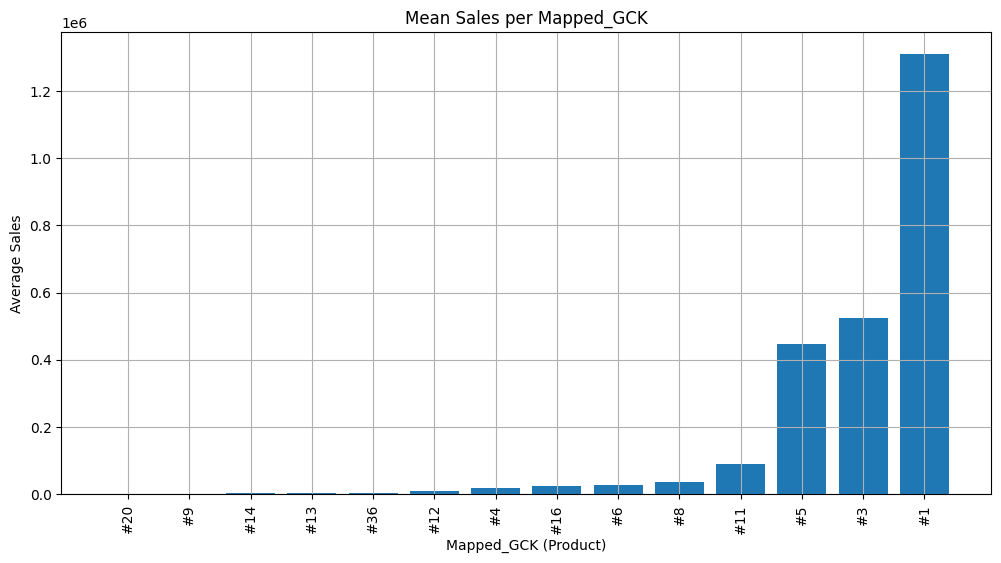

In [103]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

plt.figure(figsize=(12, 6))
plt.bar(mapped_gck_means.index, mapped_gck_means.values)
plt.xticks(rotation=90)
plt.xlabel("Mapped_GCK (Product)")
plt.ylabel("Average Sales")
plt.title("Mean Sales per Mapped_GCK")
plt.grid(True)
plt.show()

Mean Sales per Product

In [104]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

print("Mean Sales per Product:")
print(mapped_gck_means)

Mean Sales per Product:
Mapped_GCK
#20    2.672628e+02
#9     9.262072e+02
#14    2.137714e+03
#13    2.288236e+03
#36    2.300864e+03
#12    1.031065e+04
#4     1.781884e+04
#16    2.404064e+04
#6     2.599726e+04
#8     3.693975e+04
#11    9.002908e+04
#5     4.479615e+05
#3     5.245265e+05
#1     1.309759e+06
Name: Sales_EUR, dtype: float64


Check the Sales_Data

In [105]:
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR,Weekday,Year,Month
0,2018-10-01,#1,0,Monday,2018,10
1,2018-10-02,#1,0,Tuesday,2018,10
2,2018-10-03,#1,0,Wednesday,2018,10
3,2018-10-04,#1,0,Thursday,2018,10
4,2018-10-05,#1,0,Friday,2018,10


# 4. Market Data Analysis

 Preview first rows of Market Data

In [106]:
market_data.isna().sum()

0      1
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     1
12     1
13     0
14    18
15     0
16     1
17     0
18     0
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     0
27    18
28     0
29    35
30     0
31    23
32     0
33     0
34     1
35     0
36     0
37     0
38     0
39     0
40     0
41    11
42     1
43     0
44     0
45     0
46     0
47     0
dtype: int64

Clean and Reformat Market Data Header

In [107]:
market_data = market_data.drop(index=2).reset_index(drop=True)

new_columns = [
    f"{market_data.iloc[0, i]} - {market_data.iloc[1, i]}" if pd.notna(market_data.iloc[0, i]) 
    else market_data.iloc[1, i] 
    for i in range(market_data.shape[1])
]

market_data.columns = new_columns
market_data = market_data.iloc[2:].reset_index(drop=True)
market_data = market_data.rename(columns={market_data.columns[0]: "Date"})

Extract Year and Month from Date Column

In [108]:
market_data["Date"] = market_data["Date"].str.strip()
market_data["Year"] = market_data["Date"].str[:4].astype(int)
market_data["Month"] = market_data["Date"].str[5:].astype(int)

Validate Year and Month Extraction

In [109]:
year_counts = market_data["Year"].value_counts().sort_index()
month_counts = market_data["Month"].value_counts().sort_index()

In [110]:
print("Unique Years and Counts:")
print(year_counts)

Unique Years and Counts:
Year
2004    11
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022     4
Name: count, dtype: int64


In [111]:
print("\nUnique Months and Counts:")
print(month_counts)


Unique Months and Counts:
Month
1     18
2     19
3     19
4     19
5     18
6     18
7     18
8     18
9     18
10    18
11    18
12    18
Name: count, dtype: int64


# 5. Data Preparation

In [112]:
market_data = market_data.apply(pd.to_numeric, errors='coerce')
market_data.dtypes

Date                                                                 float64
China - Production Index Machinery & Electricals                     float64
China - Shipments Index Machinery & Electricals                      float64
France - Production Index Machinery & Electricals                    float64
France - Shipments Index Machinery & Electricals                     float64
Germany - Production Index Machinery & Electricals                   float64
Germany - Shipments Index Machinery & Electricals                    float64
Italy - Production Index Machinery & Electricals                     float64
Italy - Shipments Index Machinery & Electricals                      float64
Japan - Production Index Machinery & Electricals                     float64
Japan - Shipments Index Machinery & Electricals                      float64
Switzerland - Production Index Machinery & Electricals               float64
Switzerland - Shipments Index Machinery & Electricals                float64

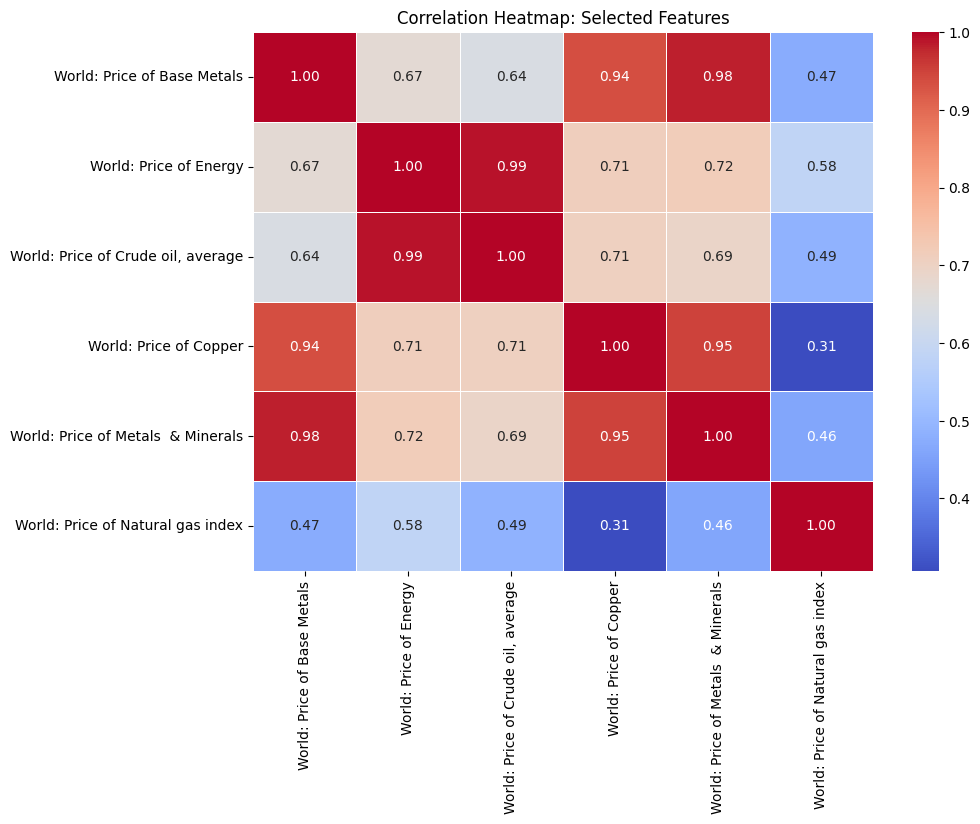

In [113]:
selected_features = [
    "World: Price of Base Metals",
    "World: Price of Energy",
    "World: Price of Crude oil, average",
    "World: Price of Copper",
    "World: Price of Metals  & Minerals",
    "World: Price of Natural gas index",
]

filtered_data = market_data[selected_features]
correlation_matrix = filtered_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Selected Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Aggregated the World Price Features

In [114]:
market_data["Key_Materials_Price_Index"] = (
    market_data["World: Price of Base Metals"] +
    market_data["World: Price of Energy"] +
    market_data["World: Price of Crude oil, average"] +
    market_data["World: Price of Copper"] +
    market_data["World: Price of Metals  & Minerals"]
) / 5

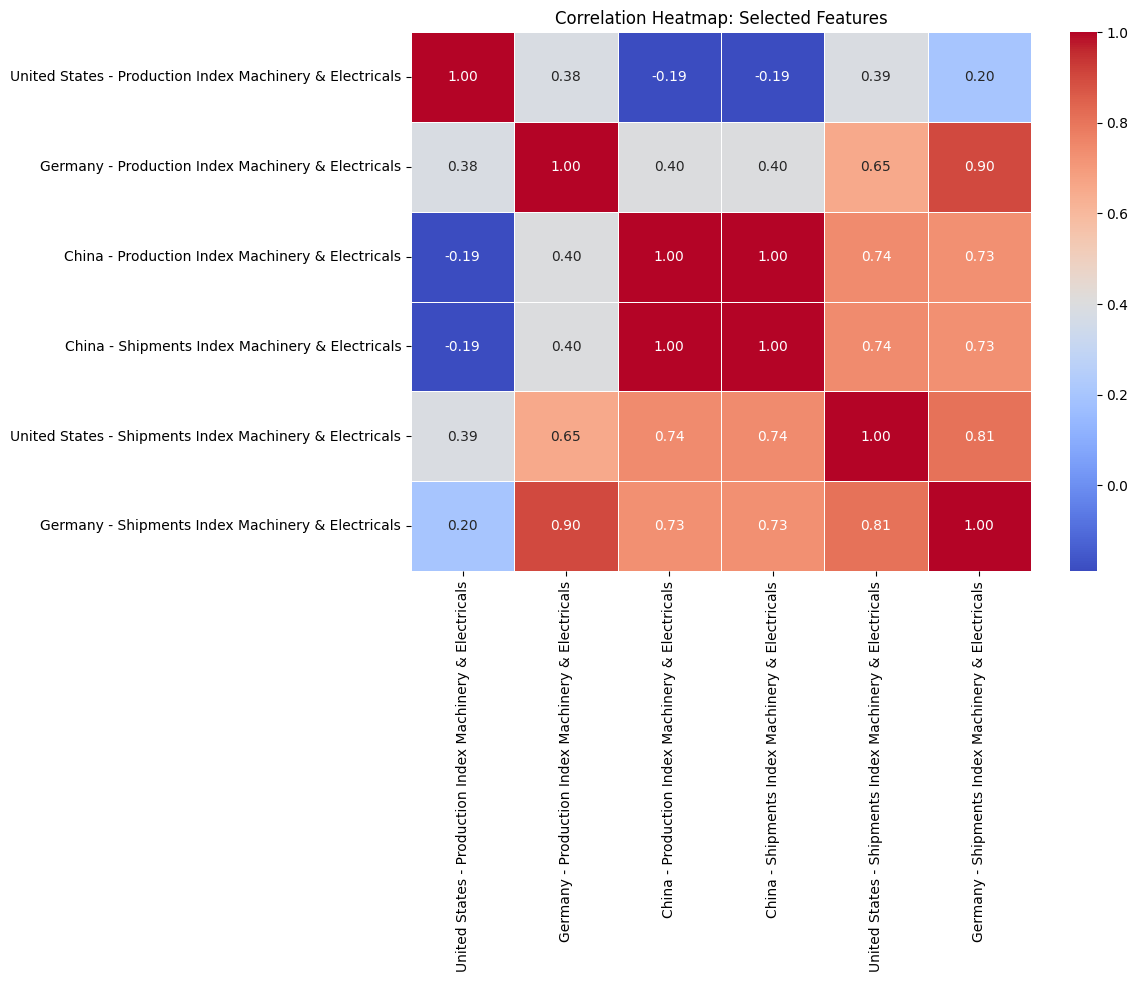

In [115]:
selected_features = [
    "United States - Production Index Machinery & Electricals",
    "Germany - Production Index Machinery & Electricals",
    "China - Production Index Machinery & Electricals",
    "China - Shipments Index Machinery & Electricals",
    "United States - Shipments Index Machinery & Electricals",
    "Germany - Shipments Index Machinery & Electricals"
]

filtered_data = market_data[selected_features]
correlation_matrix = filtered_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Selected Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [116]:
market_data["Production_Shipments_Index"] = (
    market_data["China - Shipments Index Machinery & Electricals"] +
    market_data["United States - Shipments Index Machinery & Electricals"] +
    market_data["Germany - Shipments Index Machinery & Electricals"] +
    market_data["China - Production Index Machinery & Electricals"] 
) / 4

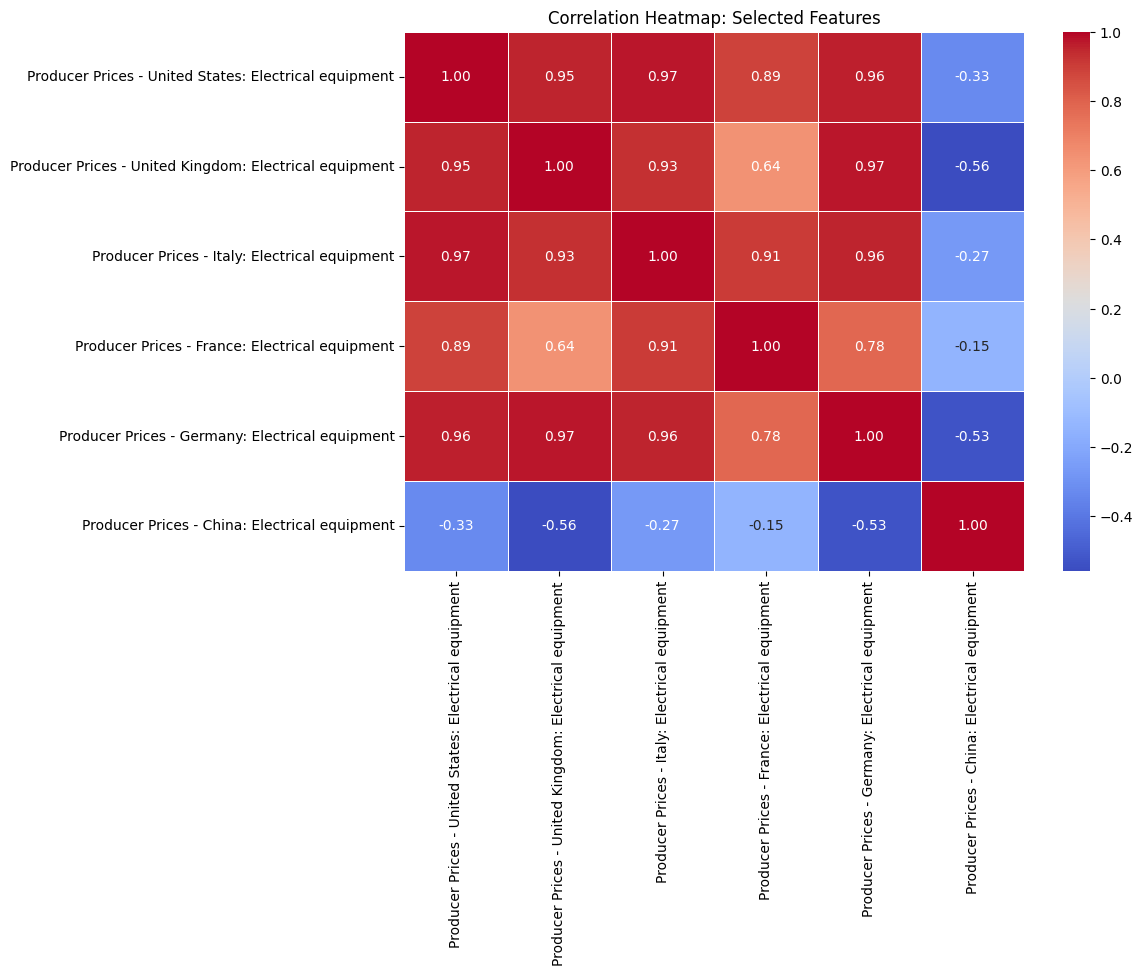

In [117]:
selected_features = [
    "Producer Prices - United States: Electrical equipment",
    "Producer Prices - United Kingdom: Electrical equipment",
    "Producer Prices - Italy: Electrical equipment",
    "Producer Prices - France: Electrical equipment",
    "Producer Prices - Germany: Electrical equipment",
    "Producer Prices - China: Electrical equipment"
]

filtered_data = market_data[selected_features]
correlation_matrix = filtered_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Selected Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [118]:
market_data["Production_Prices_Index"] = (
    market_data["Producer Prices - United States: Electrical equipment"] +
    market_data["Producer Prices - United Kingdom: Electrical equipment"] +
    market_data["Producer Prices - Italy: Electrical equipment"] +
    market_data["Producer Prices - France: Electrical equipment"] +
    market_data["Producer Prices - Germany: Electrical equipment"]
) / 5

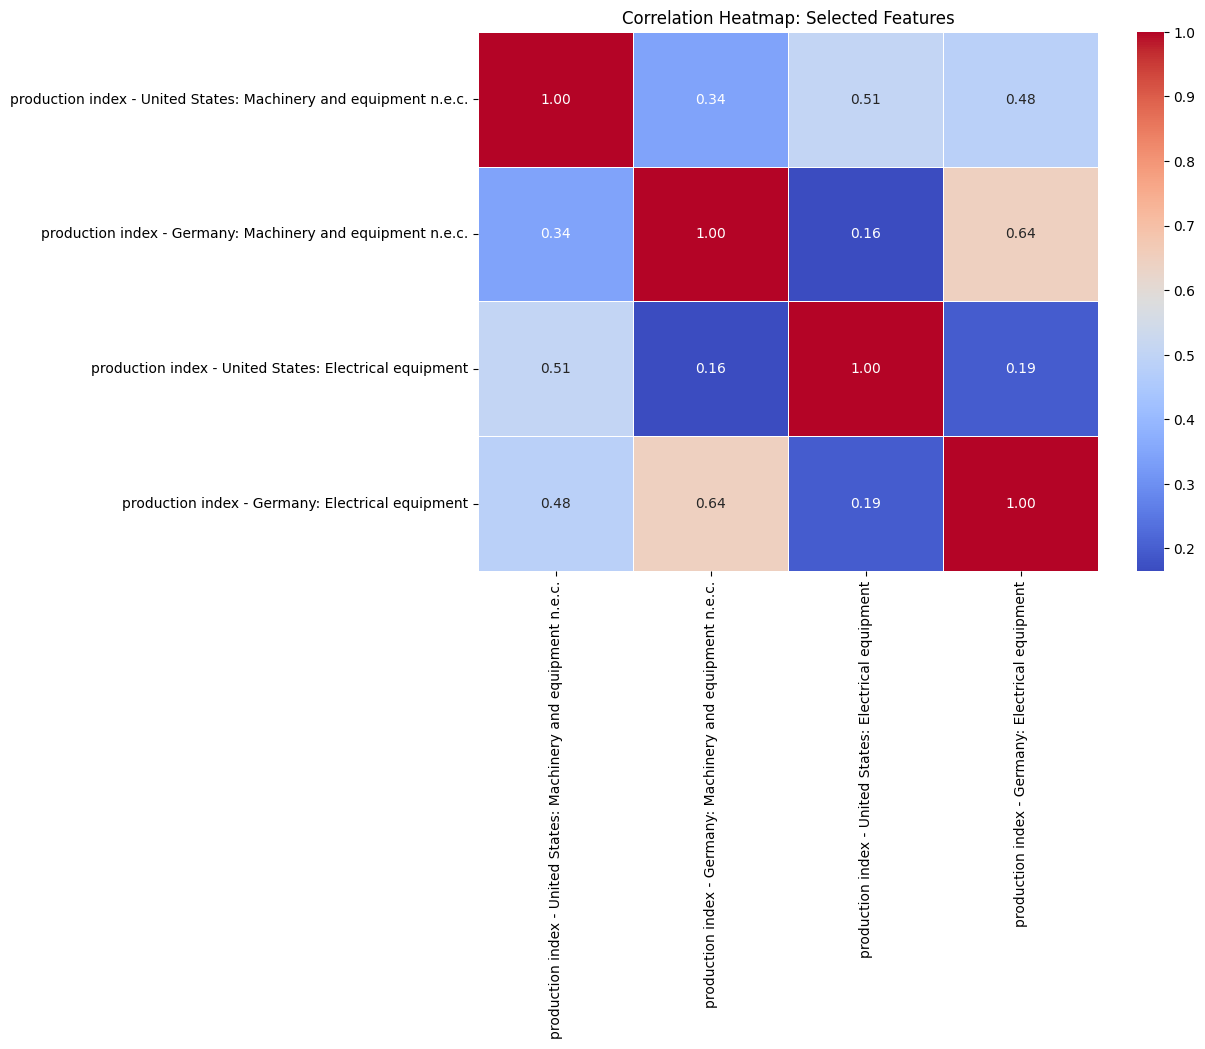

In [119]:
selected_features = [
    "production index - United States: Machinery and equipment n.e.c.",     
    "production index - Germany: Machinery and equipment n.e.c.",        
    "production index - United States: Electrical equipment",              
    "production index - Germany: Electrical equipment" 
]

filtered_data = market_data[selected_features]
correlation_matrix = filtered_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Selected Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [120]:
market_data = market_data.drop(columns=[
    "World: Price of Base Metals",
    "World: Price of Energy",
    "World: Price of Crude oil, average",
    "World: Price of Copper",
    "World: Price of Metals  & Minerals",
    "World: Price of Natural gas index",
    "Producer Prices - China: Electrical equipment",
    "China - Production Index Machinery & Electricals",
    "China - Shipments Index Machinery & Electricals",
    "United States - Shipments Index Machinery & Electricals",
    "Germany - Shipments Index Machinery & Electricals",
    "World: Price of Natural gas index",
    "Producer Prices - United States: Electrical equipment",
    "Producer Prices - United Kingdom: Electrical equipment",
    "Producer Prices - Italy: Electrical equipment",
    "Producer Prices - France: Electrical equipment",
    "Producer Prices - Germany: Electrical equipment",
    "production index - United States: Machinery and equipment n.e.c.",     
    "production index - Germany: Machinery and equipment n.e.c.",        
    "production index - United States: Electrical equipment",              
    "production index - Germany: Electrical equipment",
    "United States - Production Index Machinery & Electricals",
    "Germany - Production Index Machinery & Electricals",
    "production index - World: Machinery and equipment n.e.c.",
    'production index - Switzerland: Machinery and equipment n.e.c.',
    'production index - United Kingdom: Machinery and equipment n.e.c.',
    'production index - Italy: Machinery and equipment n.e.c.',
    'production index - Japan: Machinery and equipment n.e.c.',
    'production index - France: Machinery and equipment n.e.c.',
    'production index - World: Electrical equipment',
    'production index - Switzerland: Electrical equipment',
    'production index - United Kingdom: Electrical equipment',
    'production index - Italy: Electrical equipment',
    'production index - Japan: Electrical equipment',
    'production index - France: Electrical equipment',
    'France - Production Index Machinery & Electricals',
    'France - Shipments Index Machinery & Electricals',
    'Italy - Production Index Machinery & Electricals',
    'Italy - Shipments Index Machinery & Electricals',
    'Japan - Production Index Machinery & Electricals',
    'Japan - Shipments Index Machinery & Electricals',
    'Switzerland - Production Index Machinery & Electricals',
    'Switzerland - Shipments Index Machinery & Electricals',
    'United Kingdom - Production Index Machinery & Electricals',
    'United Kingdom - Shipments Index Machinery & Electricals',
    'Europe - Production Index Machinery & Electricals',
    'Europe - Shipments Index Machinery & Electricals',
    'United States: EUR in LCU',
])

market_data.columns.tolist()

['Date',
 'Year',
 'Month',
 'Key_Materials_Price_Index',
 'Production_Shipments_Index',
 'Production_Prices_Index']

### 7. Building the Final Dataset & Feature Selection

Merging Data to Create Final Dataset

In [121]:
market_selected = market_data[['Year', 'Month', 'Key_Materials_Price_Index', 'Production_Shipments_Index', 'Production_Prices_Index']]
merged_data = sales_data.merge(market_selected, on=["Year", "Month"], how="left")

print(merged_data.head()) 

        DATE Mapped_GCK  Sales_EUR    Weekday  Year  Month  \
0 2018-10-01         #1          0     Monday  2018     10   
1 2018-10-02         #1          0    Tuesday  2018     10   
2 2018-10-03         #1          0  Wednesday  2018     10   
3 2018-10-04         #1          0   Thursday  2018     10   
4 2018-10-05         #1          0     Friday  2018     10   

   Key_Materials_Price_Index  Production_Shipments_Index  \
0                  89.059418                  172.365576   
1                  89.059418                  172.365576   
2                  89.059418                  172.365576   
3                  89.059418                  172.365576   
4                  89.059418                  172.365576   

   Production_Prices_Index  
0               107.729254  
1               107.729254  
2               107.729254  
3               107.729254  
4               107.729254  


Converting Product Variable to Integer Type

In [122]:
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].str.replace("#", "").str.strip()
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].astype(int)

In [123]:
merged_data["Quarter"] = merged_data["Month"].apply(lambda x: (x - 1) // 3 + 1)
merged_data["Is_Holiday_Month"] = merged_data["Month"].apply(lambda x: 1 if x == 12 else 0)
merged_data["Sales_Lag_1M"] = merged_data.groupby("Mapped_GCK")["Sales_EUR"].shift(1)
merged_data["Sales_Lag_12M"] = merged_data.groupby("Mapped_GCK")["Sales_EUR"].shift(12)

In [124]:
merged_data.fillna({"Sales_Lag_1M": merged_data["Sales_EUR"].mean(),
                    "Sales_Lag_12M": merged_data["Sales_EUR"].mean()}, inplace=True)

In [125]:
merged_data = merged_data.drop(columns=["DATE", "Weekday"])

In [126]:
merged_data.columns.tolist()

['Mapped_GCK',
 'Sales_EUR',
 'Year',
 'Month',
 'Key_Materials_Price_Index',
 'Production_Shipments_Index',
 'Production_Prices_Index',
 'Quarter',
 'Is_Holiday_Month',
 'Sales_Lag_1M',
 'Sales_Lag_12M']

Correlation Matrix

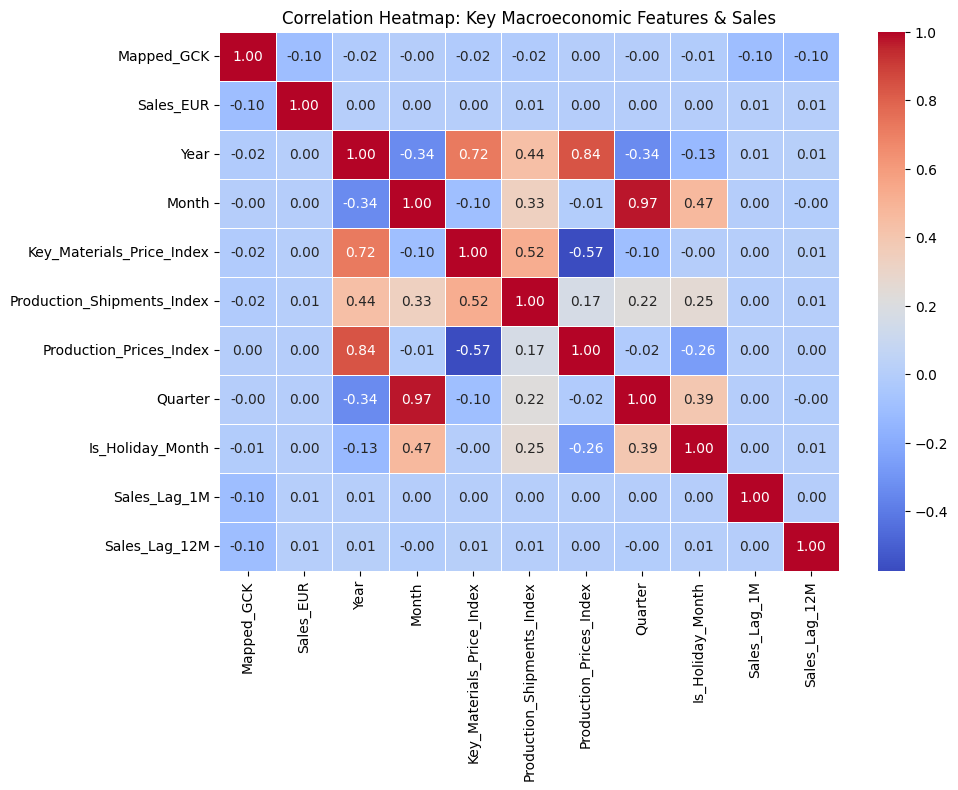

In [127]:
correlation_matrix = merged_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Key Macroeconomic Features & Sales")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [128]:
merged_data

,Mapped_GCK,Sales_EUR,Year,Month,Key_Materials_Price_Index,Production_Shipments_Index,Production_Prices_Index,Quarter,Is_Holiday_Month,Sales_Lag_1M,Sales_Lag_12M
0,1,0,2018,10,89.059418,172.365576,107.729254,4,0,272785.60457,272785.60457
1,1,0,2018,10,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457
2,1,0,2018,10,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457
3,1,0,2018,10,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457
4,1,0,2018,10,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457
...,...,...,...,...,...,...,...,...,...,...,...
9797,12,0,2019,8,75.054253,166.184151,108.932611,3,0,0.00000,0.00000
9798,36,1015,2019,8,75.054253,166.184151,108.932611,3,0,324.00000,0.00000
9799,12,0,2019,8,75.054253,166.184151,108.932611,3,0,0.00000,0.00000
9800,8,43763,2019,8,75.054253,166.184151,108.932611,3,0,-1000.00000,0.00000


Copy with "YearMonth" 

In [129]:
merged_data_2 = merged_data.copy()
merged_data_2["YearMonth"] = (
    merged_data_2["Year"].astype(str) + "-" + 
    merged_data_2["Month"].astype(str).str.zfill(2)
)

merged_data_2 = merged_data_2.drop(columns=["Year", "Month"])
merged_data_2

,Mapped_GCK,Sales_EUR,Key_Materials_Price_Index,Production_Shipments_Index,Production_Prices_Index,Quarter,Is_Holiday_Month,Sales_Lag_1M,Sales_Lag_12M,YearMonth
0,1,0,89.059418,172.365576,107.729254,4,0,272785.60457,272785.60457,2018-10
1,1,0,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457,2018-10
2,1,0,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457,2018-10
3,1,0,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457,2018-10
4,1,0,89.059418,172.365576,107.729254,4,0,0.00000,272785.60457,2018-10
...,...,...,...,...,...,...,...,...,...,...
9797,12,0,75.054253,166.184151,108.932611,3,0,0.00000,0.00000,2019-08
9798,36,1015,75.054253,166.184151,108.932611,3,0,324.00000,0.00000,2019-08
9799,12,0,75.054253,166.184151,108.932611,3,0,0.00000,0.00000,2019-08
9800,8,43763,75.054253,166.184151,108.932611,3,0,-1000.00000,0.00000,2019-08


In [130]:
numeric_cols = merged_data_2.select_dtypes(include=[np.number]).columns
merged_data_2[numeric_cols] = merged_data_2[numeric_cols].fillna(merged_data_2[numeric_cols].median())

In [131]:
merged_data_2.isna().sum()

Mapped_GCK                    0
Sales_EUR                     0
Key_Materials_Price_Index     0
Production_Shipments_Index    0
Production_Prices_Index       0
Quarter                       0
Is_Holiday_Month              0
Sales_Lag_1M                  0
Sales_Lag_12M                 0
YearMonth                     0
dtype: int64

In [132]:
data = merged_data_2.groupby(['YearMonth', 'Mapped_GCK']).agg({
    'Sales_EUR': 'sum',
    'Key_Materials_Price_Index': 'mean',
    'Production_Shipments_Index': 'mean',
    'Production_Prices_Index': 'mean',
    'Is_Holiday_Month': 'mean',
    'Sales_Lag_1M': 'mean',
    'Sales_Lag_12M': 'mean',
}).reset_index()

In [133]:
data['Sales_EUR_Log'] = np.log1p(data['Sales_EUR'])

c:\Users\jgven\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [134]:
data

,YearMonth,Mapped_GCK,Sales_EUR,Key_Materials_Price_Index,Production_Shipments_Index,Production_Prices_Index,Is_Holiday_Month,Sales_Lag_1M,Sales_Lag_12M,Sales_EUR_Log
0,2018-10,1,36098918,89.059418,172.365576,107.729254,0.0,101721.469123,112876.801891,17.401773
1,2018-10,3,8089464,89.059418,172.365576,107.729254,0.0,460642.000000,196266.043478,15.906073
2,2018-10,4,397759,89.059418,172.365576,107.729254,0.0,8905.578947,21981.631579,12.893604
3,2018-10,5,2499060,89.059418,172.365576,107.729254,0.0,36394.739130,226363.260870,14.731426
4,2018-10,6,369230,89.059418,172.365576,107.729254,0.0,23076.875000,31550.187500,12.819178
...,...,...,...,...,...,...,...,...,...,...
597,2022-04,13,17019,140.613840,185.428419,108.579825,0.0,27278.560457,57180.520914,9.742144
598,2022-04,14,1847,140.613840,185.428419,108.579825,0.0,-93.000000,45464.267428,7.521859
599,2022-04,16,134069,140.613840,185.428419,108.579825,0.0,16047.052632,48212.727037,11.806117
600,2022-04,20,6279,140.613840,185.428419,108.579825,0.0,46173.100762,45462.434095,8.745125


# 8. Modelling

Time-Based Train-Test Split

In [135]:
data['YearMonth'] = pd.to_datetime(data['YearMonth'], format='%Y-%m')
data = data.sort_values(by='YearMonth')

train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

train_data = train_data.copy()
num_cols = train_data.select_dtypes(include=[np.number]).columns
train_data[num_cols] = train_data[num_cols].fillna(train_data[num_cols].median())
test_data = test_data.copy()
num_cols_test = test_data.select_dtypes(include=[np.number]).columns
test_data[num_cols_test] = test_data[num_cols_test].fillna(test_data[num_cols_test].median())

X_train = train_data.drop(columns=["Sales_EUR"])
y_train = train_data["Sales_EUR"]
X_test = test_data.drop(columns=["Sales_EUR"])
y_test = test_data["Sales_EUR"]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (481, 9)
Testing data shape: (121, 9)


Calculating Acceptable RMSE Threshold per Product

In [136]:
ACCEPTABLE_PERCENTAGE = 20  
rmse_thresholds = []

for product_id in train_data["Mapped_GCK"].unique():
    median_sales = train_data[train_data["Mapped_GCK"] == product_id]["Sales_EUR"].median()
    threshold = (ACCEPTABLE_PERCENTAGE / 100) * median_sales
    rmse_thresholds.append([product_id, int(threshold)])

rmse_threshold_df = pd.DataFrame(rmse_thresholds, columns=["Mapped_GCK", "RMSE_Threshold"])
rmse_threshold_df

,Mapped_GCK,RMSE_Threshold
0,1,7480598
1,36,2515
2,20,183
3,16,52017
4,13,3920
5,12,30789
6,11,243285
7,14,1383
8,8,112607
9,6,104206


# Prophet

In [137]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()

y_train1 = X_train1.pop('Sales_EUR_Log')
y_test1 = X_test1.pop('Sales_EUR_Log')

X_train1['ds'] = X_train1['YearMonth']
X_test1['ds'] = X_test1['YearMonth']

X_train1['y'] = y_train1
X_test1['y'] = y_test1

m = Prophet()
m.add_regressor('Mapped_GCK')
m.fit(X_train1[['ds','y','Mapped_GCK']])

forecast_p = m.predict(X_test1[['ds','Mapped_GCK']])
forecast_p['Mapped_GCK'] = X_test1['Mapped_GCK'].values
forecast_p['actual_log'] = X_test1['y'].values

14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
results = []
for gck_value, group in forecast_p.groupby('Mapped_GCK'):
    pred_log = group['yhat']
    actual_log = group['actual_log']
    log_rmse = mean_squared_error(actual_log, pred_log, squared=False)
    pred_original = np.exp(pred_log)
    actual_original = np.exp(actual_log)
    rmse_original = mean_squared_error(actual_original, pred_original, squared=False)
    results.append({'Mapped_GCK': gck_value, 'Log_RMSE': log_rmse, 'RMSE_Original': rmse_original})

prophet_df = pd.DataFrame(results)
prophet_df

,Mapped_GCK,Log_RMSE,RMSE_Original
0,1,2.853680,3.561764e+07
1,3,2.351404,1.295542e+07
2,4,1.365342,9.534869e+05
3,5,2.584931,1.131135e+07
4,6,0.839786,4.112716e+05
5,8,1.273070,1.162536e+06
6,9,4.812702,3.684073e+05
7,11,2.133336,1.926816e+06
8,12,0.564539,1.346206e+05
9,13,1.982296,1.292946e+05


In [139]:
X_train_plot1 = X_train.copy()
X_test_plot1 = X_test.copy()

X_train_plot1['ds'] = X_train_plot1['YearMonth']
X_test_plot1['ds'] = X_test_plot1['YearMonth']

X_train_plot1['y'] = y_train1
X_test_plot1['y'] = y_test1

14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing


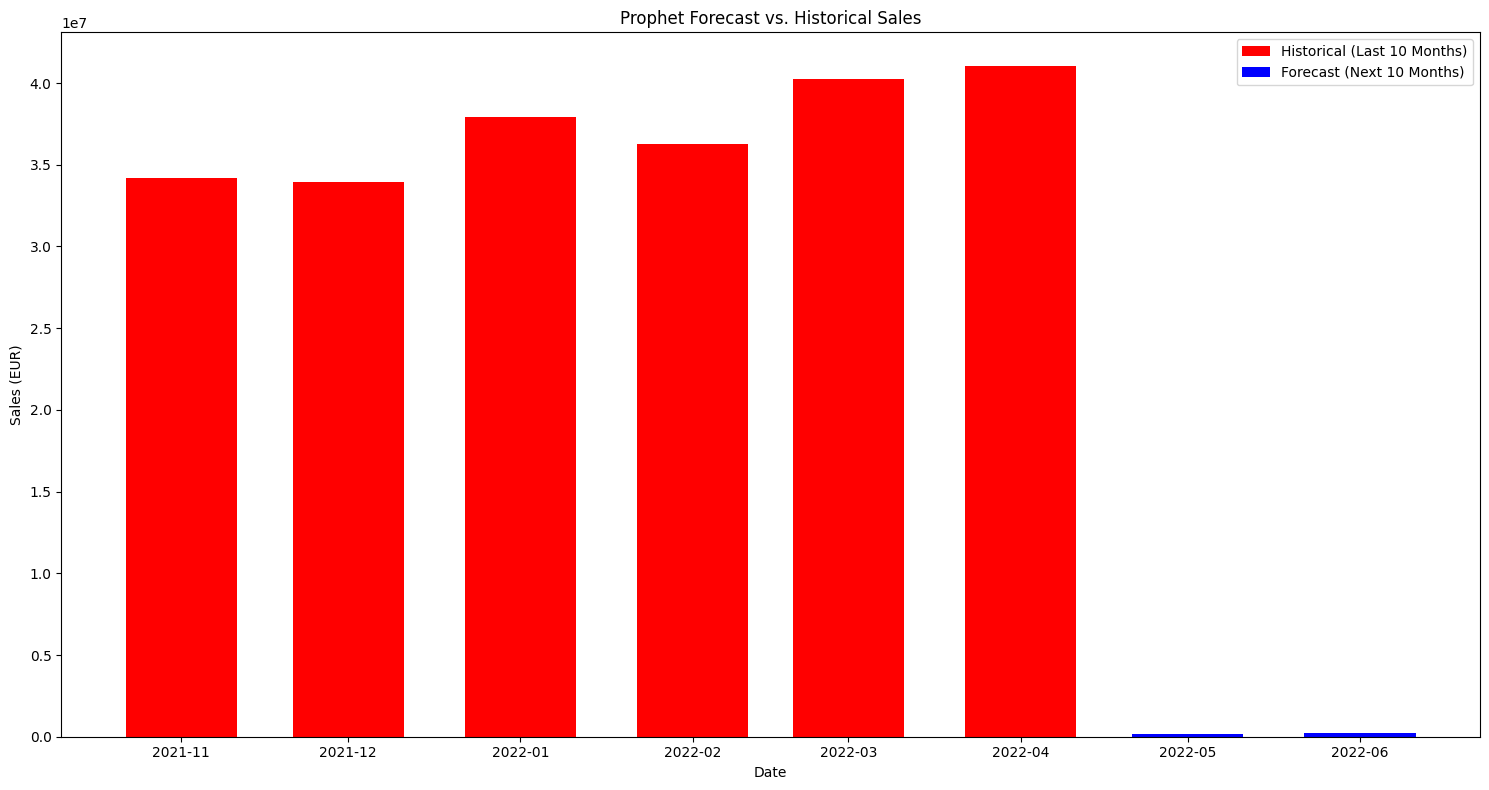

In [140]:
m1 = Prophet()
m1.fit(X_train_plot1[['ds', 'y']])

forecast_test = m1.predict(X_test_plot1[['ds']])
future_df = m1.make_future_dataframe(periods=10, freq='MS')
forecast_future = m1.predict(future_df)
forecast_future['yhat_real'] = np.exp(forecast_future['yhat'])
last_date = data['YearMonth'].max()
last_10_months = last_date - pd.DateOffset(months=5)
plot_data = data[data['YearMonth'] >= last_10_months]
forecast_to_plot = forecast_future[forecast_future['ds'] > last_date]

plt.figure(figsize=(15,8))
plt.bar(plot_data['YearMonth'], plot_data['Sales_EUR'], width=20, color='red', label='Historical (Last 10 Months)')
plt.bar(forecast_to_plot['ds'], forecast_to_plot['yhat_real'], width=20, color='blue', label='Forecast (Next 10 Months)')
plt.title('Prophet Forecast vs. Historical Sales')
plt.xlabel('Date')
plt.ylabel('Sales (EUR)')
plt.legend()
plt.tight_layout()
plt.show()

# XGB

In [141]:
X_train2 = X_train.copy()
y_train2 = X_train2.pop('Sales_EUR_Log')

X_test2 = X_test.copy()
y_test2 = X_test2.pop('Sales_EUR_Log')

X_train2.drop(columns=['YearMonth'], inplace=True, errors='ignore')
X_test2.drop(columns=['YearMonth'], inplace=True, errors='ignore')

In [142]:
model = xgb.XGBRegressor()
model.fit(X_train2, y_train2)

pred_log = model.predict(X_test2)
X_test2['pred_log'] = pred_log
X_test2['actual_log'] = y_test2

X_test2.dropna(subset=['actual_log'], inplace=True)

results = []
for gck_value, group in X_test2.groupby('Mapped_GCK'):
    plog = group['pred_log']
    alog = group['actual_log']
    log_rmse = mean_squared_error(alog, plog, squared=False)
    p_original = np.exp(plog)
    a_original = np.exp(alog)
    rmse_original = mean_squared_error(a_original, p_original, squared=False)
    results.append({
        'Mapped_GCK': gck_value,
        'Log_RMSE': log_rmse,
        'RMSE_Original': rmse_original
    })

xgb_df = pd.DataFrame(results)
xgb_df

,Mapped_GCK,Log_RMSE,RMSE_Original
0,1,0.132936,4.798544e+06
1,3,0.218264,2.936512e+06
2,4,0.421282,1.308771e+05
3,5,0.529914,5.803689e+06
4,6,0.584598,2.058806e+05
5,8,0.516532,7.344166e+05
6,9,2.640621,1.537238e+05
7,11,1.263603,6.625659e+05
8,12,0.361493,1.022861e+05
9,13,2.176868,6.714844e+04


# RF

In [143]:
X_train3 = X_train.copy()
y_train3 = X_train3.pop('Sales_EUR_Log')

X_test3 = X_test.copy()
y_test3 = X_test3.pop('Sales_EUR_Log')

X_train3['YearMonth'] = pd.to_datetime(X_train3['YearMonth'], format='%Y-%m')
X_test3['YearMonth'] = pd.to_datetime(X_test3['YearMonth'], format='%Y-%m')

X_train3['Year'] = X_train3['YearMonth'].dt.year
X_train3['Month'] = X_train3['YearMonth'].dt.month
X_test3['Year'] = X_test3['YearMonth'].dt.year
X_test3['Month'] = X_test3['YearMonth'].dt.month

X_train3.drop(columns=['YearMonth'], inplace=True)
X_test3.drop(columns=['YearMonth'], inplace=True)

In [144]:
model = RandomForestRegressor()
model.fit(X_train3, y_train3)

pred_log = model.predict(X_test3)
X_test3['pred_log'] = pred_log
X_test3['actual_log'] = y_test3

X_test3.dropna(subset=['actual_log'], inplace=True)

results = []
for gck_value, group in X_test3.groupby('Mapped_GCK'):
    plog = group['pred_log']
    alog = group['actual_log']
    log_rmse = mean_squared_error(alog, plog, squared=False)
    p_original = np.exp(plog)
    a_original = np.exp(alog)
    rmse_original = mean_squared_error(a_original, p_original, squared=False)
    results.append({
        'Mapped_GCK': gck_value,
        'Log_RMSE': log_rmse,
        'RMSE_Original': rmse_original
    })

rf_df = pd.DataFrame(results)
rf_df

,Mapped_GCK,Log_RMSE,RMSE_Original
0,1,0.070089,2.720570e+06
1,3,0.306006,3.478986e+06
2,4,0.418695,1.382478e+05
3,5,0.533632,4.589626e+06
4,6,0.825854,2.010482e+05
5,8,0.530167,7.823582e+05
6,9,2.597005,1.625735e+05
7,11,1.279968,7.512397e+05
8,12,0.375702,9.484513e+04
9,13,1.968952,1.577899e+05


# SARIMA

In [145]:
X_train4 = X_train.copy()
y_train4 = X_train4.pop('Sales_EUR_Log')

X_test4 = X_test.copy()
y_test4 = X_test4.pop('Sales_EUR_Log')

model = SARIMAX(
    y_train4, 
    order=(1,1,1), 
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False, 
    enforce_invertibility=False
)

results_sarima = model.fit(disp=False)
pred_log = results_sarima.forecast(steps=len(y_test4))

X_test4['pred_log'] = pred_log.values
X_test4['actual_log'] = y_test4.values
X_test4.dropna(subset=['actual_log'], inplace=True)

results = []
for gck_value, group in X_test4.groupby('Mapped_GCK'):
    plog = group['pred_log']
    alog = group['actual_log']
    
    log_rmse = mean_squared_error(alog, plog, squared=False)
    p_original = np.exp(plog)
    a_original = np.exp(alog)
    rmse_original = mean_squared_error(a_original, p_original, squared=False)
    
    results.append({
        'Mapped_GCK': gck_value,
        'Log_RMSE': log_rmse,
        'RMSE_Original': rmse_original
    })

sarima_df = pd.DataFrame(results)
sarima_df

c:\Users\jgven\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jgven\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jgven\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jgven\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a sup

,Mapped_GCK,Log_RMSE,RMSE_Original
0,1,5.249290,3.777941e+07
1,3,4.185547,1.422023e+07
2,4,0.474140,1.167630e+05
3,5,3.955396,1.198435e+07
4,6,0.748412,2.906555e+05
5,8,1.763039,1.317805e+06
6,9,4.535322,2.857184e+05
7,11,2.158904,1.945561e+06
8,12,0.938888,2.163875e+05
9,13,2.563056,2.911962e+05


In [146]:
plt.figure(figsize=(25, 6))

if 'Historical_Sales' in merged_df.columns:
    plt.plot(
        merged_df['YearMonth'],
        merged_df['Historical_Sales'],
        label='Historical Sales',
        color='black'
    )

# Plot each forecast
if 'Prophet_Forecast' in merged_df.columns:
    plt.plot(
        merged_df['YearMonth'],
        merged_df['Prophet_Forecast'],
        label='Prophet Forecast'
    )
if 'XGB_Forecast' in merged_df.columns:
    plt.plot(
        merged_df['YearMonth'],
        merged_df['XGB_Forecast'],
        label='XGBoost Forecast'
    )
if 'RF_Forecast' in merged_df.columns:
    plt.plot(
        merged_df['YearMonth'],
        merged_df['RF_Forecast'],
        label='Random Forest Forecast'
    )
if 'SARIMA_Forecast' in merged_df.columns:
    plt.plot(
        merged_df['YearMonth'],
        merged_df['SARIMA_Forecast'],
        label='SARIMA Forecast'
    )

plt.title('10-Month Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 2500x600 with 0 Axes>

In [ ]:
prophet_df = prophet_df.rename(
    columns={'Log_RMSE': 'Prophet_Log_RMSE', 'RMSE_Original': 'Prophet_RMSE_Original'}
)
xgb_df = xgb_df.rename(
    columns={'Log_RMSE': 'XGB_Log_RMSE', 'RMSE_Original': 'XGB_RMSE_Original'}
)
rf_df = rf_df.rename(
    columns={'Log_RMSE': 'RF_Log_RMSE', 'RMSE_Original': 'RF_RMSE_Original'}
)
sarima_df = sarima_df.rename(
    columns={'Log_RMSE': 'SARIMA_Log_RMSE', 'RMSE_Original': 'SARIMA_RMSE_Original'}
)

comparison_df = (
    prophet_df
    .merge(xgb_df, on='Mapped_GCK')
    .merge(rf_df, on='Mapped_GCK')
    .merge(sarima_df, on='Mapped_GCK')
)

comparison_df

## Analysis of Forecasting Results

The table shows **four models** (Prophet, XGBoost, Random Forest, SARIMA) evaluated on each product category (`Mapped_GCK`), with both **log-scale RMSE** (`*_Log_RMSE`) and **original-scale RMSE** (`*_RMSE_Original`). Here’s how to interpret the data:

1. **Row-by-Row Comparison**  
   - Each row corresponds to a specific `Mapped_GCK` value (i.e., a product category).  
   - For each model, compare `RMSE_Original` to see which model yields the **lowest** absolute error in raw sales units. A lower `RMSE_Original` indicates more accurate forecasts for that category.  
   - The `Log_RMSE` columns show how well each model performs in **relative** terms (important if sales range widely across categories).

2. **Identifying the Best Model per Category**  
   - Look across each row to see which model has the **smallest** `RMSE_Original`. That model produces the least absolute error for that specific `Mapped_GCK`.  
   - In some rows, XGBoost might have the lowest RMSE; in others, Random Forest or SARIMA might perform better. This indicates no single model dominates every category.

3. **Overall Performance**  
   - You can compute the **mean** or **median** of `RMSE_Original` for each model across all `Mapped_GCK`. Whichever model has the **lowest average** typically delivers the best overall forecasts.  
   - Similarly, if you care about percentage errors, compare the **average `Log_RMSE`**. A lower log RMSE means the model fits more closely on a relative scale.

4. **Business Considerations**  
   - If certain product lines (`Mapped_GCK` values) are more critical, focus on the model that performs best for those key categories.  
   - A model with the lowest overall RMSE might still be outperformed on specific products by another model.

5. **Conclusion**  
   - If Random Forest has the lowest **average** `RMSE_Original`, it is likely the best overall choice for absolute-accuracy goals.  
   - If XGBoost consistently wins on `Log_RMSE`, it might handle relative errors better (especially if sales vary greatly).  
   - Prophet or SARIMA might excel if strong seasonal patterns exist, but they can be outperformed in datasets with more complex or non-seasonal behaviors.

In [ ]:
print("Prophet Avg RMSE:", prophet_df["Prophet_RMSE_Original"].mean())
print("XGB Avg RMSE:", xgb_df["XGB_RMSE_Original"].mean())
print("RF Avg RMSE:", rf_df["RF_RMSE_Original"].mean())
print("SARIMA Avg RMSE:", sarima_df["SARIMA_RMSE_Original"].mean())

## Conclusion

Based on the average RMSE (on the original sales scale) across all products (`Mapped_GCK`):

- **Prophet Average RMSE:** 4,658,852  
- **XGBoost Average RMSE:** 1,126,589  
- **Random Forest Average RMSE:** 927,276  
- **SARIMA Average RMSE:** 4,964,939  

Random Forest achieves the **lowest** overall RMSE (approximately 927k), indicating it produces the most accurate forecasts in terms of absolute error among the four models tested. XGBoost is the second-best performer, while Prophet and SARIMA have higher average errors in this particular dataset.

# Save Results

In [ ]:
test_set_template = pd.read_csv('test_set_template.csv')

# Assuming that you already have your predicted values as 'forecasted_sales' (the predicted sales)
# You should align 'forecasted_sales' with the 'YearMonth' from the test data
# For example:
# forecasted_sales = model.predict(X_test)  # Replace this with your actual model predictions

# Create a DataFrame for predicted values (aligning with the test data)
forecasted_results = pd.DataFrame({
    'YearMonth': test_data['YearMonth'],  # 'YearMonth' from the test set
    'Forecasted_Sales': forecasted_sales  # Replace with your actual forecasted sales
})

# Now, merge the forecasted results with the template (matching YearMonth)
final_results = pd.merge(test_set_template, forecasted_results, on="YearMonth", how="left")

# Export the final results to a CSV file
final_results.to_csv('/mnt/data/final_forecasted_results.csv', index=False)

# Display the result file path
print("The forecasted results have been saved to 'final_forecasted_results.csv'.")